# Real Time News Project - Prototype

Everyday I am bombarded by news, from many places. Even Google News gives me at least 3 or 4 times the same news, but from different sources.

My idea for the project (so far) is a service of real time news based on twitter posts. A kind of Mashable, but with auto news and auto classification of the news for easy view and no repetition of news.

The news could be classified as well based on its sentiment to whether it is a "good" news or "bad" news.


### The problem

As Data Science, the problems that I see are:

    - Find the "best" links (news) to show. What is the concept of best? Is this the most retweeted? Is the news that comes from a very popular user (lots of followers)?
    - Urls may come from different person, but the source is the same. I need to make sure that I have the final news, not multiple urls for the same source.
    - Classify according to the topic of the news and filter spams
    - Deduplicate the same news that came from multiple places.
    - Classify according to the sentiment.

### Solution Overview

To achieve the goal of the project, the following steps need to be done:

- Data acquisition and Analysis
    - I'll be using the twitter stream api to gather the tweets with urls. 
    - I want to use Spark Streaming for data aquisition but I could use the python tweepy, used on this prototype
- Data Preparation
    - for each tweet, I need to identify if they are spam
    - fetch the news from the original source
    - filter properties like language, urls that lead only to photos and no news.
    - Spark is my intended tool to use on this part.
- Model training
    - Create/find a good topic corpus for topic classification
    - Create a model for identify spams
    - Create, train and validate models for the topic, sentiment and deduplication
    - The benchmark for the quality of the news is going to be news that are on the trending topics and are on my system / that are on google news.
    - Python will be used on this part. Probably a mix of Scikit, ntlk, gensim, pattern and Sparks's MLLib
- Presentation
    - The news and other computation information will be presented on a meteor made website that uses AngularJS and Material Design
    - Maybe give an option for the user to re classify a news if it is not correct

## Prototype

In [1]:
%pylab inline
import json
from IPython.lib.display import IFrame
import seaborn as sns
import numpy as np

Populating the interactive namespace from numpy and matplotlib


### The Data

The data for this prototype came from Twitter's stream api. The data has 2.8GB of data, 560k tweets collect from `Jul 18 17:35:17 +0000 2015` to `Sat Jul 18 20:36:09 +0000 2015` using the filter http only.

The script below uses SPARK to do the processing, using the VM provided on EDX course [Introduction to Big Data with Apache Spark](https://www.edx.org/course/introduction-big-data-apache-spark-uc-berkeleyx-cs100-1x)

In [2]:
raw = sc.textFile('./tweet_cache.txt')

#### SIMPLE COUNT OF TWITS WITH THE URL

The first metric that I thought of using was the number of tweets with the same URL. Basically, get all the tweets and count the number of times the url appeared. But that was not a very good metric.

In [3]:
def check_url(tweet):
    '''
    Verify if there is a valid URL in the tweet
    :param tweet: a String with the what should be a dictionary
    : return a valid url
    '''
    ret = []
    # load the tweet to a dictionary and get the full url param
    tweet_dic = json.loads(tweet)
    entities = tweet_dic.get('entities', None)
    if entities:
        urls = entities.get(u'urls', '')
        for url in urls:
             ret.append(url.get('expanded_url', url.get('url', '')))

    return ret

    

In [4]:
# remove blank lines, get all the urls, emit a (url,1 pair) for a count of most posts 
urls_rd = raw.filter(lambda l: l != '').flatMap(lambda l: check_url(l)).filter(lambda l: l != '').map(lambda l: (l,1))

In [5]:
# sum the (url, 1) pairs
urls_array = urls_rd.reduceByKey(lambda a,b: a+b).sortBy(lambda l: -l[1] ).collect()

In [76]:
print 'Total Number of URLS: %d' % len(urls_array)
print 'Mean of amount of times the url appear: %f' % np.mean([ u[1] for u in urls_array])
print 'Median of amount of times the url appear: %f' % np.median([ u[1] for u in urls_array])
print 'SD of amount of times the url appear: %f' % np.std([ u[1] for u in urls_array])

Total Number of URLS: 190900
Mean of amount of times the url appear: 1.562404
Median of amount of times the url appear: 1.000000
SD of amount of times the url appear: 22.422330


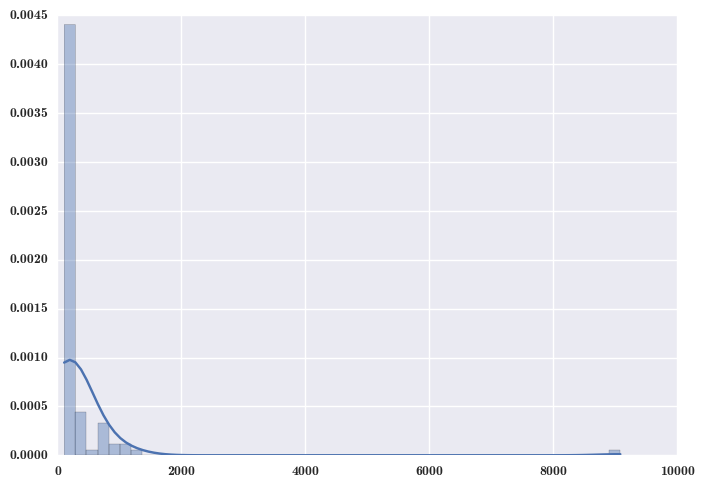

In [77]:
# plot the first hundred most repeated url
sns.distplot([ u[1] for u in urls_array[0:100]]);

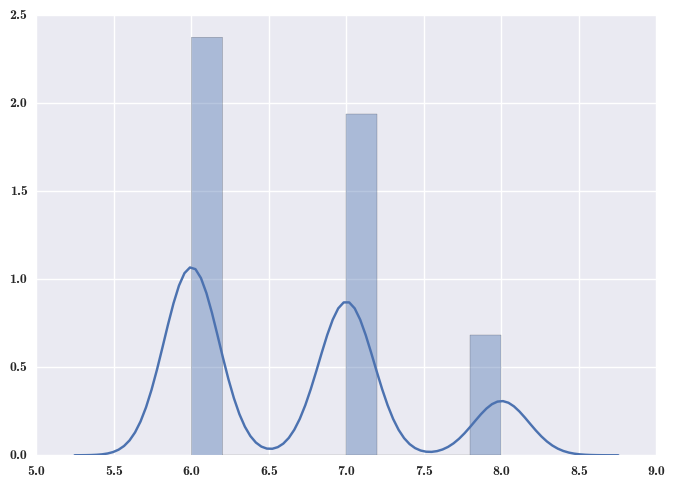

In [78]:
# plot the first hundred most repeated url
sns.distplot([ u[1] for u in urls_array[2000:3000]]);

The distribution has a long tail. That means that few are very present and others not so much. Let's have a look on 3 of the "best" urls I have:

In [6]:
urlnum = 1
print 'Opening', urls_array[0]
IFrame(urls_array[0][0], 800,300)

Opening (u'http://qurani.tv', 9077)


In [7]:
# other examples
print 'Opening', urls_array[urlnum*2]
IFrame(urls_array[urlnum*2][0], 800,300)

Opening (u'http://Gharedly.Com', 1116)


In [8]:
print 'Opening', urls_array[urlnum*20]
IFrame(urls_array[urlnum*20][0], 800,300)

Opening (u'http://i-qra.com/t/3081/', 303)


So, no real news so far. Lets have a look on why it happens:

In [9]:
urls_array[0:10]

[(u'http://qurani.tv', 9077),
 (u'http://fllwrs.com', 1222),
 (u'http://Gharedly.Com', 1116),
 (u'http://gigam.es/imtw_Tribez', 1066),
 (u'http://mipersonahoy.com/descubrir/', 925),
 (u'http://www.crowdfireapp.com/?r=td', 864),
 (u'http://zad-muslim.com', 757),
 (u'http://www.tuitutil.net', 724),
 (u'http://goo.gl/2Izmua', 724),
 (u'http://bit.do/o_4', 681)]

![caption](Other/image1.png)

You will probably not understand as it is in portuguese, but all this guys are saying completly different things but with the same link. **SO, i can say that I just found a network of spammers (or infected accounts). Actually, 724 profiles.**

Conclusion: I could get a trend on twitter. That SPAM is transmitted A LOT of times with a lot of twits. Not a good metric.

#### COUNTS OF FOLLOWERS AS METRIC

Number of tweets is not a good metrics, so let's try with number of followers/friends. Twitter basically put the news on your stream if you are following someone. 

The average number of clicks on a Google Adwords campaign is 4% of the visualization. I don't have the number of people that see a post as when you log into Twitter it will show you the most recent tweets on your timeline. But we can say that the probability of somebody reading a news from a big source is bigger than when it comes from a small source.

In [10]:
def get_url_follower(tweet):
    '''
    Count the number of friends and foloowers for the user who is tweeting the url
    :param tweet:  String with json represantation of tweet
    : return a tuple with (url, (follower_count, 1))
    '''
    ret = []
    # load the tweet to a dictionary and get the full url param
    tweet_dic = json.loads(tweet)
    entities = tweet_dic.get('entities', None)
    user = tweet_dic.get('user') 
    c = 0
    print user
    if user:
        c = user.get('friends_count', 0) + user.get('followers_count', 0)
    if entities:
        urls = entities.get(u'urls', '')
        for url in urls:
            u = url.get('expanded_url', url.get('url', ''))
            ret.append((u,(c,1)))

    return ret    

In [27]:
# filter lines with tweets, and sum the number of folower/friends as well as the count
urls_rd = raw.filter(lambda l: l != '').flatMap(lambda l: get_url_follower(l))
urls_array = urls_rd.reduceByKey(lambda a,b: (a[0]+b[0],a[1]+b[1])).sortBy(lambda l: -l[1][0] ).collect()
urls_array[0:10]

[(u'http://goo.gl/2Izmua', (54176518, 724)),
 (u'http://myh.airtrick.co/SH5J', (29023789, 409)),
 (u'http://HydrohsClothing.Com', (20488994, 257)),
 (u'http://qurani.tv', (19884545, 9077)),
 (u'http://nyti.ms/1RBZYeS', (18062115, 6)),
 (u'http://f.itness.co/SH4Aa', (16262020, 208)),
 (u'http://myn.atural.me/SH8A', (15886667, 209)),
 (u'http://c.heatersfound.com/SH456', (14129520, 199)),
 (u'http://6-pack.co/4O6amk', (9724567, 110)),
 (u'http://econ.st/1MeGRnx', (9499930, 1))]

In [12]:
print 'Total Number of URLS: %d' % len(urls_array)
print 'Mean of friends count: %f' % np.mean([ u[1][0] for u in urls_array])
print 'Median of friends count: %f' % np.median([ u[1][0] for u in urls_array])
print 'SD of friends count: %f' % np.std([ u[1][0] for u in urls_array])

Total Number of URLS: 190900
Mean of friends count: 16077.289686
Median of friends count: 890.500000
SD of friends count: 225333.865272


/usr/lib/pymodules/python2.7/matplotlib/font_manager.py:1236: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/lib/pymodules/python2.7/matplotlib/font_manager.py:1246: UserWarning: findfont: Could not match :family=Bitstream Vera Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0. Returning /usr/share/matplotlib/mpl-data/fonts/ttf/cmb10.ttf
  UserWarning)


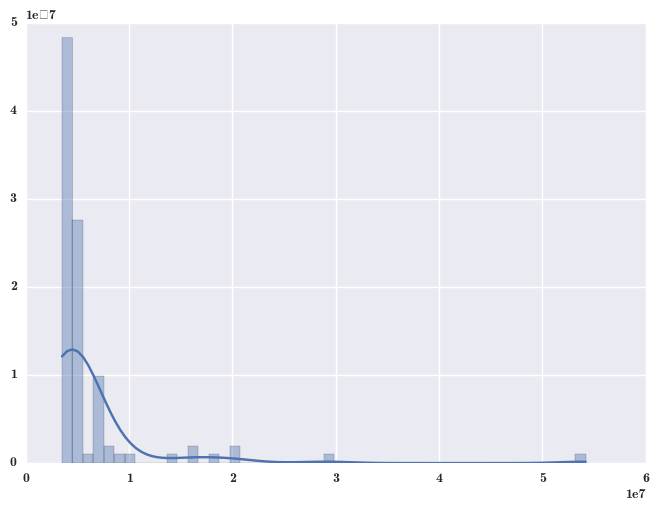

In [13]:
# plot the first hundred most powerful urls based on number of friends
sns.distplot([ u[1][0] for u in urls_array[0:100]]);

#### Only ENGLISH Tweets

For this prototype I will be using only English tweets as the sentiment and topic analysis are easier to do on this language.

In [14]:
def to_dict(tweet):
    '''
    Convert the saved tweet as json to a dictionary
    :param tweet: a String with json represantation of tweet
    : return a dict representing the tweet
    '''
    ret = []
    # load the tweet to a dictionary and get the full url param
    tweet_dic = json.loads(tweet)
    return tweet_dic

In [15]:
def get_url_follower_from_dict(tweet_dic):
    '''
    Verify if there is a valid URL in the tweet
    :param tweet: a String with the what should be a dictionary
    : return a valid url
    '''
    ret = []
    # load the tweet to a dictionary and get the full url param
    entities = tweet_dic.get('entities', None)
    user = tweet_dic.get('user') 
    c = tweet_dic.get('retweet_count', 0) 
    print user
    if user:
        c += user.get('friends_count', 0) + user.get('followers_count', 0) 
    if entities:
        urls = entities.get(u'urls', '')
        for url in urls:
            u = url.get('expanded_url', url.get('url', ''))
            ret.append((u,(c,1)))

    return ret    

In [28]:
# get only english tweets, sum the amount of followers and the amount of tweets that had the url
urls_rd = (raw
            .filter(lambda l: l != '')
            .map(lambda l: to_dict(l))
            .filter(lambda td: td.get('lang', '')=='en')
            .flatMap(lambda l: get_url_follower_from_dict(l)))
urls_array = (urls_rd
                .reduceByKey(lambda a,b: (a[0]+b[0],a[1]+b[1]))
                .sortBy(lambda l: -l[1][0])
                .collect())
urls_array[0:10]    

[(u'http://myh.airtrick.co/SH5J', (29023789, 409)),
 (u'http://HydrohsClothing.Com', (20488994, 257)),
 (u'http://nyti.ms/1RBZYeS', (18062115, 6)),
 (u'http://f.itness.co/SH4Aa', (16262020, 208)),
 (u'http://myn.atural.me/SH8A', (15886667, 209)),
 (u'http://c.heatersfound.com/SH456', (14129520, 199)),
 (u'http://6-pack.co/4O6amk', (9724567, 110)),
 (u'http://econ.st/1MeGRnx', (9499930, 1)),
 (u'http://ti.me/1Mhc3m8', (7741724, 4)),
 (u'http://thesun.uk/6015BDQYd', (7630845, 204))]

Let's check some of the urls:

1. Urls with many tweets
2. Urls with few tweets

In [17]:
IFrame('http://myh.airtrick.co/SH5J', 800,350)

In [18]:
IFrame('http://ti.me/1Mhc3m8', 800,350)

The problem of spam is not over yet, but there seems to be a pattern here. Url with many tweets are spam, the others are not. Probably I can use a machine learning here to separate the spam and not spam

### Download the pages

In [32]:
from pattern.web import download, plaintext

# Download the page from time 
html = download('http://ti.me/1Mhc3m8', unicode=True)
html[0:1000]

u'<!DOCTYPE html>\n<!--[if IE 8]>\n<html class="no-js lt-ie9 is-ie"> <![endif]-->\n<!--[if IE 9]>\n<html class="no-js is-ie"> <![endif]-->\n<!--[if gt IE 9]><!-->\n<html class="no-js"> <!--<![endif]-->\n<head>\n\t<meta charset="utf-8">\n\t<title>Footage of Young Queen Elizabeth Giving Nazi Salute Causes Controversy</title>\n\t<meta name="viewport" content="width=device-width,minimum-scale=1.0,maximum-scale=1.0">\n\t<meta name="apple-mobile-web-app-capable" content="yes">\n\t<meta name="apple-mobile-web-app-status-bar-style" content="black-translucent">\n\t<meta name="msapplication-TileColor" content="#FFFFFF">\n\t<meta name="msapplication-TileImage" content="https://s0.wp.com/wp-content/themes/vip/time2014/img/time-touch_icon_152.png">\n\t<!--[if lt IE 9]>\n\t<script src="https://s0.wp.com/wp-content/themes/vip/time2014/js/dist/html5shiv.js"></script><![endif]--><script>\n\twindow._sf_async_config = {};\n\twindow._sf_async_config.uid = 3088;\n\twindow._sf_async_config.domain = \'time.c

In [33]:
# clean the text
s = plaintext(html)
s[0:1000]

u'Footage of Young Queen Elizabeth Giving Nazi Salute Causes Controversy\n\nTime.com\n\nSubscribe\n\nSign InSign Out\n\nHomeU.S.PoliticsWorldBusinessTechHealthScienceEntertainmentNewsfeedLivingSportsHistoryThe TIME VaultMagazineIdeasParentsTIME Labs\n\nMoneyLIFEThe Daily Cut\n\nPhotographyVideos\n\nPittsburgh: The ComebackNext Generation LeadersThe 100 Most Influential PeopleAsk the ExpertKnow Right NowNew AdventurersPerson of the Year 2014Shaping Our FutureSolutions That MatterTIME ExplainsTop 10 Everything of 2014Top of the WorldWonders of the WorldA Year In Space\n\nSubscribeNewslettersFeedbackPrivacy PolicyYour California Privacy RightsTerms of UseAd Choices\n\nRSSTIME AppsTIME for KidsAdvertisingReprints and PermissionsSite MapHelpCustomer Service\xa9 2015 Time Inc. All rights reserved.\n\nDavid Sweat Details How He Escaped From Prison\n\nHome-sharing Company Airbnb Is After More Business Users\n\nSee What JFK Airport\u2019s Extravagant New \u2018Pet Terminal\u2019 Will Look Like\

### Topic Analysis

One of the expected features is to put the news into some topic, that intersts the reader. Lets do it in a simple way.

In [21]:
### Topic analysis
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [22]:
## get the 20 newsgroup training set, creating the word vector
newsgroups_train = fetch_20newsgroups(subset='train')
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(newsgroups_train.data)

## train a Multinomial Naive Bayes
clf = MultinomialNB(alpha=.01)
clf.fit(vectors, newsgroups_train.target)

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

In [23]:
# create the word vector for the text
article_words = vectorizer.transform([s])

# predict the topic for the article
pred = clf.predict(article_words)

# print the topic
print ' the topic for this article is: %s'  % newsgroups_train.target_names[pred]

 the topic for this article is: talk.politics.guns


Ok, not spetacular but it is something. It knows it is about politics. Maybe a more suited corpus would work better, but ok for a prototype.

### Sentiment Analysis

In [24]:
from pattern.en import sentiment

In [25]:
# check the sentiment analysis for one news
w = sentiment(s)
print 'Polarity (neg ↔ pos),  subjectivity (objective ↔ subjective)'
w

Polarity (neg ↔ pos),  subjectivity (objective ↔ subjective)


(0.10636209029066171, 0.347595856524428)

In [26]:
# lets see the words
print w.assessments

[([u'young'], 0.1, 0.4, None), ([u'daily'], 0.0, 0.0, None), ([u'most'], 0.5, 0.5, None), ([u'right'], 0.2857142857142857, 0.5357142857142857, None), ([u'more'], 0.5, 0.5, None), ([u'new'], 0.13636363636363635, 0.45454545454545453, None), ([u'real', '!'], 0.25, 0.30000000000000004, None), ([u'arrest'], -0.05, 0.0, None), ([u'dead'], -0.2, 0.4, None), ([u'new'], 0.13636363636363635, 0.45454545454545453, None), ([u'new'], 0.13636363636363635, 0.45454545454545453, None), ([u'iconic'], 0.5, 0.5, None), ([u'blue'], 0.0, 0.1, None), ([u'young'], 0.1, 0.4, None), ([u'british'], 0.0, 0.0, None), ([u'later'], 0.0, 0.0, None), ([u'sympathetic'], 0.5, 1.0, None), ([u'long'], -0.05, 0.4, None), ([u'subject'], -0.16666666666666666, 0.3333333333333333, None), ([u'historical'], 0.0, 0.0, None), ([u'disappointing'], -0.6, 0.7, None), ([u'apparently'], 0.05, 0.35, None), ([u'personal'], 0.0, 0.3, None), ([u'own'], 0.6, 1.0, None), ([u'military'], -0.1, 0.1, None), ([u'historical'], 0.0, 0.0, None), ([u

Not really a positive news. The threshold could be higher and the corpus could be different.